XGBoost Script for Hemauer, Saunders, and Desmarais

Last updated: 05/31/2025

In [ ]:
### Preprocessing

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import warnings

warnings.filterwarnings('ignore')

random.seed(1337)

# Data
boehmke_2017_full = pd.read_stata(r"boehmke_analysis\replication_data\boehmke2017.dta")

covariates = ["srcs_decay","nbrs_lag","rpcpinc","totpop","legp_squire",
                "citi6010","unif_rep","unif_dem","time","time_sq","time_cube"]
boehmke_2017 = boehmke_2017_full[["state", "year", "statepol", "adopt"] + covariates].dropna()

# Encode 'state'
X = boehmke_2017.drop(columns=['adopt', 'year', 'statepol']).copy()
X = pd.get_dummies(X, columns=['state'], drop_first = True)  # drop_first avoids perfect multicollinearity
y = boehmke_2017['adopt']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337, stratify = y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

F1 Macro Score: 0.5364666005291006
Balanced Accuracy: 0.5260816569410319
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      8448
         1.0       0.42      0.06      0.10       444

    accuracy                           0.95      8892
   macro avg       0.68      0.53      0.54      8892
weighted avg       0.93      0.95      0.93      8892

Average Precision (AUC PR): 0.1730


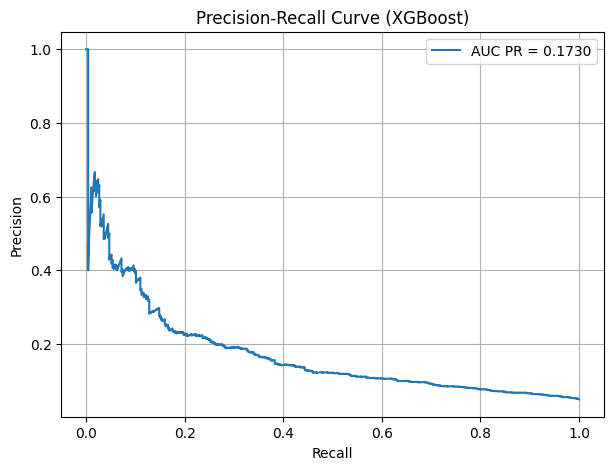

In [ ]:
### Boehmke et al. 2017 XGBoost (No Optimization)

# Fit
xgb = XGBClassifier(random_state = 1337, use_label_encoder = False, n_jobs = -1)

start_time = time.time()
xgb.fit(X_train_scaled, y_train)
end_time = time.time()

# Predict
y_pred = xgb.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = xgb.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### Boehmke et al. 2017 XGBoost (Optimized)

# Define the parameter search space for BayesSearchCV
param_grid = {
    'n_estimators': (100, 300, 500),
    'max_depth': (3, 7, 15, 30),
    'max_bin': (16, 32, 64, 128),
    'booster': ['gbtree', 'dart'],
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss', 'auc', 'error', 'aucpr'],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'grow_policy': ['depthwise', 'lossguide'],
    'learning_rate': (0.001, 0.01, 0.1),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 2),
    'reg_alpha': (0, 2),
    'reg_lambda': (0, 2),
    'min_child_weight': (1, 5, 10),
    'max_leaves': (0, 16, 32),
    'scale_pos_weight': (1, 5, 10)
}

bayes_search = BayesSearchCV(
    estimator = XGBClassifier(random_state = 1337, use_label_encoder = False),
    search_spaces = param_grid,
    n_iter = 128,
    cv = 10,
    n_jobs = -1,
    verbose = 0,
    scoring = 'f1',
    random_state = 1337
)

start_time = time.time()
bayes_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"BayesSearchCV took {end_time - start_time:.2f} seconds")
print("Best parameters found:", bayes_search.best_params_)

# Get the best model
best_model = bayes_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()